In [51]:
import torch

def setseed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
torch.cuda.empty_cache()
setseed(42)
print("Seed set successfully")


Seed set successfully


## Losses

In [52]:
import torch
import torch.nn.functional as F

def image_normalization(image, pixel_value_offset=128.0, pixel_value_scale=128.0):
    """
    Normalizes an image tensor by subtracting an offset and dividing by a scale.
    Typically used to convert [0,255] RGB values into a normalized range.
    
    Args:
        image (torch.Tensor): Input image of shape [C, H, W] or [B, C, H, W].
        pixel_value_offset (float): Value to subtract from each pixel.
        pixel_value_scale (float): Value to divide each pixel after offset.
    
    Returns:
        torch.Tensor: Normalized image tensor.
    """
    return (image - pixel_value_offset) / pixel_value_scale

def descriptor_global_loss(inp, out):
    """
    Computes the L2 loss between the input and output global descriptors.
    
    Args:
        inp (dict): Dictionary containing 'global_descriptor' tensor of shape [B, D].
        out (dict): Dictionary containing 'global_descriptor' tensor of shape [B, D].
    
    Returns:
        torch.Tensor: Scalar L2 loss for each sample in the batch, shape [B].
    """
    d = torch.square((inp['global_descriptor'] - out['global_descriptor']))
    return torch.sum(d, dim=-1) / 2

def descriptor_local_loss(inp, out):
    """
    Computes the L2 loss for local descriptors, which are spatial feature maps.
    
    Args:
        inp (dict): Contains 'local_descriptor_map' of shape [B, C, H, W].
        out (dict): Contains 'local_descriptor_map' of shape [B, C, H, W].
    
    Returns:
        torch.Tensor: L2 loss map of shape [B, H, W].
                     Each pixel's loss is averaged across channels.
    """
    d = torch.square(inp['local_descriptor_map'] - out['local_descriptor_map'])
    # Sum over channels and divide by 2
    d = torch.sum(d, dim=-1) / 2
    return d

def detector_loss(inp, out, config, threshold=0.5):
    """
    Computes cross-entropy loss for keypoints or dense scores.
    
    Args:
        inp (dict): Must contain either 'keypoint_map' or 'dense_scores'.
                    - 'keypoint_map' should be [B, 1, H, W] or [B, C, H, W].
                    - 'dense_scores' should be [B, C, H, W].
        out (dict): Contains 'logits' of shape [B, C, H, W].
        config (dict): Configuration dictionary with 'local_head' subkey 'detector_grid'.
        threshold (float): Not currently used directly in the function, but
                           included for future modifications (e.g., if you need
                           to threshold logits or labels).
    
    Returns:
        torch.Tensor: Scalar cross-entropy loss.
    """
    logits = out['logits']  # [B, C, H, W]
    B, C, H, W = logits.shape
    grid_size = config['local_head']['detector_grid']

    if 'keypoint_map' in inp: # Hard Labels
        labels = inp['keypoint_map']  # e.g. [B, 1, H, W]
        loss = F.binary_cross_entropy_with_logits(logits,labels)

    elif 'dense_scores' in inp: # Soft labes
        # If dense_scores is used as a multi-class probability map or similar
        labels = inp['dense_scores']  # [B, C, H, W]
        loss = F.cross_entropy(logits, labels)

    else:
        raise ValueError("Input must contain 'keypoint_map' or 'dense_scores'.")

    return loss


## HF-Net

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init

class VLAD(nn.Module):
    def __init__(self, config):
        super(VLAD, self).__init__()
        self.intermediate_proj = config.get('intermediate_proj', None)
        if self.intermediate_proj:
            self.pre_proj = nn.Conv2d(240, self.intermediate_proj, kernel_size=1)

        self.n_clusters = config['n_clusters']
        self.memberships = nn.Conv2d(240, self.n_clusters, kernel_size=1)

        # Cluster centers
        self.clusters = nn.Parameter(torch.empty(1, self.n_clusters, 240))
        self._initialize_weights()  # Initialize the cluster weights

    def _initialize_weights(self):
        # Xavier initialization for cluster weights
        init.xavier_uniform_(self.clusters)

    def forward(self, feature_map, mask=None):
        if self.intermediate_proj:
            feature_map = self.pre_proj(feature_map)

        batch_size, _, h, w = feature_map.size()

        # Compute memberships (soft-assignment)
        memberships = F.softmax(self.memberships(feature_map), dim=1)

        # Reshape feature_map and clusters for broadcasting
        feature_map = feature_map.permute(0, 2, 3, 1).unsqueeze(3)  # (B, H, W, 1, D)
        residuals = self.clusters - feature_map  # Compute residuals
        residuals = residuals * memberships.permute(0, 2, 3, 1).unsqueeze(4)  # Weight residuals by memberships

        if mask is not None:
            residuals = residuals * mask.unsqueeze(-1).unsqueeze(-1)

        # Sum residuals to form the VLAD descriptor
        descriptor = residuals.sum(dim=[1, 2])

        # Intra-normalization
        descriptor = F.normalize(descriptor, p=2, dim=-1)

        # Flatten descriptor and apply L2 normalization
        descriptor = descriptor.view(batch_size, -1)
        descriptor = F.normalize(descriptor, p=2, dim=1)

        return descriptor

class DimensionalityReduction(nn.Module):
    def __init__(self, config, proj_regularizer=None):
        """
        Initializes the Dimensionality Reduction module.

        Args:
            input_dim (int): Dimension of the input feature descriptor.
            output_dim (int): Dimension of the reduced descriptor.
            proj_regularizer (float, optional): L2 regularization strength. If None, no regularization is applied.
        """
        super(DimensionalityReduction, self).__init__()
        input_dim = config['n_clusters'] * 240
        output_dim = config['dimensionality_reduction']
        self.proj_regularizer = proj_regularizer

        # Fully connected layer with Xavier initialization
        self.fc = nn.Linear(input_dim, output_dim)
        nn.init.xavier_uniform_(self.fc.weight)

        # Optional L2 regularization
        if proj_regularizer is not None:
            self.regularizer = lambda w: proj_regularizer * torch.sum(w ** 2)
        else:
            self.regularizer = None

    def forward(self, descriptor):
        """
        Forward pass for the Dimensionality Reduction module.

        Args:
            descriptor (torch.Tensor): Input feature descriptor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Reduced and normalized descriptor of shape (batch_size, output_dim).
        """
        # Normalize the input descriptor
        descriptor = F.normalize(descriptor, p=2, dim=-1)

        # Apply the fully connected layer
        descriptor = self.fc(descriptor)

        # Normalize the output descriptor
        descriptor = F.normalize(descriptor, p=2, dim=-1)

        # Apply regularization if specified
        if self.regularizer is not None:
            reg_loss = self.regularizer(self.fc.weight)
            return descriptor, reg_loss

        return descriptor

class LocalHead(nn.Module):
    def __init__(self, config):
        super(LocalHead, self).__init__()
        descriptor_dim = config['descriptor_dim']
        detector_grid = config['detector_grid']

        # Descriptor Head
        self.desc_conv1 = nn.Conv2d(config['input_channels'], descriptor_dim, kernel_size=3, stride=1, padding=1)
        self.desc_bn1 = nn.BatchNorm2d(descriptor_dim)
        self.desc_conv2 = nn.Conv2d(descriptor_dim, descriptor_dim, kernel_size=1, stride=1, padding=0)

        # Detector Head
        self.det_conv1 = nn.Conv2d(config['input_channels'], 128, kernel_size=3, stride=1, padding=1)
        self.det_bn1 = nn.BatchNorm2d(128)
        self.det_conv2 = nn.Conv2d(128, detector_grid ** 2, kernel_size=1, stride=1, padding=0)

        self.detector_grid = detector_grid

    def forward(self, features):
        # Descriptor Head
        desc = F.relu6(self.desc_bn1(self.desc_conv1(features)))
        desc = self.desc_conv2(desc)
        desc = F.normalize(desc, p=2, dim=1)

        # Detector Head
        logits = F.relu6(self.det_bn1(self.det_conv1(features)))
        logits = self.det_conv2(logits)
        logits = F.pixel_shuffle(logits, self.detector_grid)
        
        prob = F.sigmoid(logits)

        return desc, logits, prob


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class HFNet(nn.Module):
    def __init__(self, config, width_mult=1.0):
        super(HFNet, self).__init__()
        # [expand_ratio, channels, repeats, stride]
        self.cfgs = [
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 1, 2],
            [6,  64, 1, 1],
            [6, 128, 1, 1],
            [6, 64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        image_channels = config['image_channels']
        # Feature Extractor (MobileNetV2 backbone)
        input_channel = _make_divisible(32 * width_mult, 8)
        layers = [conv_3x3_bn(image_channels, input_channel, 2)]
        block = InvertedResidual
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # Keypoint Detector Head
        self.local_head = LocalHead(config['local_head'])

        # Descriptor Head
        self.global_head = nn.Sequential(
            VLAD(config['global_head']),
            DimensionalityReduction(config['global_head'])
        )
        self.logvars = nn.Parameter(torch.tensor([1.0, 1.0, 1.0], requires_grad=True))
        self._initialize_weights()

    def forward(self, x):
        x = image_normalization(x)
        # Backbone
        features_1 = self.features[:7](x)
        features_2 = self.features[7:](features_1)

        # local_head
        desc, logits, prob = self.local_head(features_1)

        # Classification (if needed)
        descriptor = self.global_head(features_2)

        return {'local_descriptor_map':desc,
                'logits':logits,
                'dense_scores':prob,
                'global_descriptor':descriptor,
                'image_shape':x.shape
                }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def _compute_loss(self, inputs, outputs, config):
        """Computes the total loss using external loss functions."""
        desc_g = descriptor_global_loss(inputs, outputs).mean()
        desc_l = descriptor_local_loss(inputs, outputs).mean()
        detect = detector_loss(inputs, outputs, config).mean()

        # Apply weighting
        if config['loss_weights'] == 'uncertainties':
            w = {f'logvar_{i}': logvar.item() for i, logvar in enumerate(self.logvars)}
            precisions = [torch.exp(-logvar) for logvar in self.logvars]
            total_loss = desc_g * precisions[0] + (self.logvars[0])
            total_loss += desc_l * precisions[1] + (self.logvars[1])
            total_loss += 2 * detect * precisions[2] + (self.logvars[2])
        else:
            w = config['loss_weights']
            total_loss = (
                (w['global'] * desc_g + w['local'] * desc_l + w['detector'] * detect) /
                sum(w.values())
            )
        

        return total_loss, {
            'global_desc_l2': desc_g.item(),
            'local_desc_l2': desc_l.item(),
            'detector_crossentropy': detect.item()
        }, w

In [54]:
    image = torch.randn(1, 1, 480, 640)

    config= {
    'image_channels':1,
    'loss_weights': 'uncertainties',
    'local':{
        'detector_threshold': 0.001,
        'nms_radius': 4,
        'num_keypoints': 10000
    },
    'local_head': {
        'descriptor_dim': 128,
        'detector_grid': 8,
        'input_channels': 96
    },
    'global_head': {
        'n_clusters': 32,
        'intermediate_proj': 0,
        'dimensionality_reduction': 4096
        }
    }
    model = HFNet(config, width_mult=0.75)

    ret = model(image)
    for k, v in ret.items():
        if k != "image_shape":
            print(k,v.shape)

local_descriptor_map torch.Size([1, 128, 60, 80])
logits torch.Size([1, 1, 480, 640])
dense_scores torch.Size([1, 1, 480, 640])
global_descriptor torch.Size([1, 4096])


### Prediction

In [55]:
import torch
import torch.nn.functional as F

def simple_nms(scores, radius, iterations=3):
    """
    Performs non-maximum suppression (NMS) on a 2D heatmap using max-pooling.

    Args:
        scores (torch.Tensor): 2D tensor of shape [H, W] representing the heatmap.
        radius (int): Neighborhood radius for local maxima.
        iterations (int): Number of NMS iterations to apply.

    Returns:
        torch.Tensor: Heatmap with non-maxima suppressed to zero.
    """
    size = 2 * radius + 1

    def max_pool(x):
        # Temporarily add batch & channel dims for max_pool2d
        return F.max_pool2d(x.unsqueeze(0).unsqueeze(0), kernel_size=size, stride=1, padding=radius).squeeze()

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)

    for _ in range(iterations - 1):
        suppression_mask = max_pool(max_mask.float()).bool()
        suppressed_scores = torch.where(suppression_mask, zeros, scores)
        new_max_mask = suppressed_scores == max_pool(suppressed_scores)
        max_mask |= new_max_mask & ~suppression_mask

    return torch.where(max_mask, scores, zeros)


def predict(ret, config):
    """
    Extracts keypoints and local descriptors from model outputs.

    Args:
        ret (dict): Dictionary containing:
            - 'dense_scores': [B, 1, H, W] score maps
            - 'local_descriptor_map': [B, C, H', W'] descriptor maps
            - 'image_shape': shape info for scaling keypoints
        config (dict): Configuration dict with 'local' sub-dict specifying
                       nms_radius, detector_threshold, num_keypoints, etc.

    Returns:
        dict: Updated 'ret' with new keys:
              'keypoints', 'scores', 'local_descriptors'
    """
    dense_scores = ret['dense_scores'].squeeze(1)  # shape: [B, H, W]
    batch_size = dense_scores.shape[0]

    keypoints_list, scores_list, descriptors_list = [], [], []

    for b in range(batch_size):
        # Apply NMS if specified
        scores = dense_scores[b]
        if config['local'].get('nms_radius', 0) > 0:
            scores = simple_nms(scores, config['local']['nms_radius'])

        # Threshold keypoints
        mask = scores >= config['local']['detector_threshold']
        keypoints = torch.nonzero(mask, as_tuple=False)  # [N, 2]
        kp_scores = scores[keypoints[:, 0], keypoints[:, 1]]

        # Keep top-k if specified
        k = config['local'].get('num_keypoints', None)
        if k is not None and k > 0:
            k = min(keypoints.shape[0], k)
            kp_scores, idx = torch.topk(kp_scores, k)
            keypoints = keypoints[idx]

        # Reshape to [1, N, 2], flip to [x, y]
        keypoints = keypoints.unsqueeze(0).flip(-1)
        kp_scores = kp_scores.unsqueeze(0)

        # Prepare descriptor map
        desc_map = ret['local_descriptor_map'][b].unsqueeze(0)  # [1, C, H', W']
        _, C, H_desc, W_desc = desc_map.shape

        # Extract original image shape to scale keypoints
        _, _, H_img, W_img = ret['image_shape']
        scale = torch.tensor([W_desc - 1, H_desc - 1], device=scores.device, dtype=torch.float32)
        scale /= torch.tensor([W_img - 1, H_img - 1], device=scores.device, dtype=torch.float32)
        scale = scale.flip(0)  # [H_scale, W_scale]

        # Scale keypoints to descriptor map size
        keypoints_scaled = keypoints.float() * scale.unsqueeze(0).unsqueeze(0)

        # Normalize keypoints for grid_sample to [-1, 1]
        norm_kpts = keypoints_scaled.clone()
        norm_kpts[..., 0] = (norm_kpts[..., 0] / (W_desc - 1)) * 2 - 1
        norm_kpts[..., 1] = (norm_kpts[..., 1] / (H_desc - 1)) * 2 - 1

        # Sample descriptors
        grid = norm_kpts.unsqueeze(2)  # [1, N, 1, 2]
        local_desc = F.grid_sample(desc_map, grid, align_corners=True)  # [1, C, N, 1]
        local_desc = local_desc.squeeze(-1).permute(0, 2, 1)           # [1, N, C]
        local_desc = F.normalize(local_desc, p=2, dim=-1)

        keypoints_list.append(keypoints)
        scores_list.append(kp_scores)
        descriptors_list.append(local_desc)

    # Stack results for the batch
    device = dense_scores.device
    ret.update({
        'keypoints': torch.stack(keypoints_list).to(device),
        'scores': torch.stack(scores_list).to(device),
        'local_descriptors': torch.stack(descriptors_list).to(device)
    })
    
    return ret


## Post-processing

In [56]:
import torch
import torch.nn.functional as F

def desc4silk(ret,out):
    """
    Upsample `local_descriptor_map` from [B, 128, 60, 80] to [B, 128, 480, 640]
    using `F.grid_sample()`.
    out: silk output including descriptor_position 
    """
    # Extract relevant tensors from the input dictionary
    dense_scores = ret['dense_scores']  # shape: [B, H, W]
    keypoints = out['keypoints'].long()  # shape: [N, 2]
    desc_map = ret['local_descriptor_map']  # [1, C, H', W']
    _, C, H_desc, W_desc = desc_map.shape

    # Extract original image shape to scale keypoints
    _, _, H_img, W_img = ret['image_shape']
    scale = torch.tensor([H_desc - 1, W_desc - 1], device=keypoints.device, dtype=torch.float32)
    scale /= torch.tensor([H_img - 1, W_img - 1], device=keypoints.device, dtype=torch.float32)

    # Scale keypoints to descriptor map size
    keypoints_scaled = keypoints.float() * scale.unsqueeze(0).unsqueeze(0)

    # Normalize keypoints for grid_sample to [-1, 1]
    norm_kpts = keypoints_scaled.clone()
    norm_kpts[..., 0] = (norm_kpts[..., 0] / (W_desc - 1)) * 2 - 1
    norm_kpts[..., 1] = (norm_kpts[..., 1] / (H_desc - 1)) * 2 - 1

    # Sample descriptors
    grid = norm_kpts.unsqueeze(2)  # [1, N, 1, 2]
    local_desc = F.grid_sample(desc_map, grid, align_corners=True)  # [1, C, N, 1]
    local_desc = local_desc.squeeze(-1).permute(0, 2, 1)           # [1, N, C]
    local_desc = F.normalize(local_desc, p = 2, dim =-1)

    ret['local_descriptor_map'] = local_desc

    return ret


torch.manual_seed(42)

# Example usage
ret = {
    'dense_scores': torch.rand(1, 480, 640),        # shape: [B, H, W]
    'local_descriptor_map': torch.rand(1, 128, 60, 80),  # shape: [B, 128, H', W']
    'image_shape': torch.rand(1, 1, 480, 640).shape
}
out = {
    'keypoints': torch.rand((100,2))*100
}
print(out['keypoints'][:5])
rets = desc4silk(ret,out)
print(rets['local_descriptor_map'].shape)  # Expected: [1, 128, 480, 640]


tensor([[79.7267, 36.3293],
        [71.5480, 14.8105],
        [77.2471,  7.2567],
        [67.1530, 34.6592],
        [16.0746, 62.6228]])
torch.Size([1, 100, 128])


## Load Data

In [57]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from PIL import Image
import os

In [58]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    """
    A dataset class that:
      - Loads an image from 'image_dir'
      - Loads corresponding global and local descriptors from 'glo_dir' and 'loc_dir'
      - Selects top-k keypoints by score
      - Constructs descriptor and keypoint maps at the image resolution
    """
    def __init__(
        self,
        image_dir: str,
        glo_dir: str,
        loc_dir: str,
        num: int,
        num_keypoints: int,
        transform=None
    ):
        """
        Args:
            image_dir (str): Directory containing images.
            glo_dir (str): Directory containing global descriptors (.npz files).
            loc_dir (str): Directory containing local descriptors/keypoints (.npz files).
            num (int): Number of samples to load.
            num_keypoints (int): Number of top keypoints to keep based on scores.
            transform (callable, optional): Transform to be applied on the PIL image.
        """
        self.image_dir = image_dir
        self.glo_dir = glo_dir
        self.loc_dir = loc_dir
        self.num_keypoints = num_keypoints
        self.transform = transform

        # Collect file names, sorted for consistent ordering
        self.image_files = sorted(os.listdir(image_dir))[:num]
        self.glo_files = sorted(os.listdir(glo_dir))[:num]
        self.loc_files = sorted(os.listdir(loc_dir))[:num]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Returns:
            image (torch.Tensor): The transformed image of shape [C, H, W].
            inp (dict): Dictionary containing:
                "global_descriptor" (torch.Tensor),
                "keypoint_map" (torch.Tensor of shape [1, H, W]),
                "local_descriptor_map" (torch.Tensor of shape [128, H, W])
        """
        # File paths
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        glo_path = os.path.join(self.glo_dir, self.glo_files[idx])
        loc_path = os.path.join(self.loc_dir, self.loc_files[idx])
        
        # Load and transform the image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)  # shape: [C, H, W]

        # Load descriptors
        glo_data = np.load(glo_path)
        loc_data = np.load(loc_path)

        glo = {k: torch.from_numpy(v) for k, v in glo_data.items()}
        loc = {k: torch.from_numpy(v) for k, v in loc_data.items()}

        # Extract local data
        scores = loc['scores'].squeeze(-1)         # shape: [N]
        keypoints = loc['keypoint']               # shape: [N, 2]
        local_descriptors = loc['local_descriptor_map']  # shape: [N, 128]
        

        # Select top-k keypoints
        topk_indices = scores.topk(self.num_keypoints, largest=True).indices
        keypoints = keypoints[topk_indices].long()
        scores = scores[topk_indices]
        local_descriptors = local_descriptors[topk_indices]
        local_descriptors = F.normalize(local_descriptors, p=2, dim =-1)

        # Build descriptor & keypoint maps
        _, H_img, W_img = image.shape  # shape: [C, H, W]
        keypoint_map = torch.zeros(1, H_img, W_img)
        
        # Place scores in the keypoint map
        keypoint_map[:, keypoints[:, 0], keypoints[:, 1]] = scores
        # keypoint_map = F.normalize(keypoint_map, p=2, dim =0)

        # Build dictionary
        inp = {
            "global_descriptor": glo['global_descriptor'],
            "keypoint_map": keypoint_map,
            "local_descriptor_map": local_descriptors,
            "keypoints": keypoints
        }

        return image, inp


In [59]:
import os
import torch
import random
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

def setseed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print("set seed successful")

setseed(42)

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.5
    ),
    transforms.ToTensor(),
])

# --- Paths ---
dataset_path = '/kaggle/input/google-landmarks-tiny/images'
global_path = '/kaggle/input/global-descriptors/global_descriptors'
local_path = '/kaggle/input/silk-exported/silk_predictions'

# --- Dataset Initialization ---
data_set = CustomImageDataset(
    image_dir=dataset_path,
    glo_dir=global_path,
    loc_dir=local_path,
    num=1000,          # Number of images to load
    num_keypoints=10000,
    transform=transform
)

# --- Train/Val/Test Split ---
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
BATCH_SIZE = 1

train_size = int(TRAIN_RATIO * len(data_set))
val_size = int(VAL_RATIO * len(data_set))
test_size = len(data_set) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    data_set,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# --- Dataloaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,     
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


In [60]:
for k, v in data_set:
    print(k.shape)
    for k1,v1 in v.items():
        if k1  == 'local_descriptor_map' or k1 =='keypoint_map' :
            print(k1,v1.shape)
    break

torch.Size([1, 480, 640])
keypoint_map torch.Size([1, 480, 640])
local_descriptor_map torch.Size([10000, 128])


In [61]:
for image, label in train_loader:
    print(image.shape)
    for k, v in label.items():
        print(k,v.shape)
    break

torch.Size([1, 1, 480, 640])
global_descriptor torch.Size([1, 4096])
keypoint_map torch.Size([1, 1, 480, 640])
local_descriptor_map torch.Size([1, 10000, 128])
keypoints torch.Size([1, 10000, 2])


## Training 

In [62]:
import torch
import matplotlib.pyplot as plt

def visualize_heatmaps(pred_logits, gt_heatmap):
    """
    Visualize predicted and ground truth heatmaps side by side.

    Args:
        pred_logits (torch.Tensor): Model's raw output, shape [1, 1, H, W].
        gt_heatmap (torch.Tensor): Ground truth heatmap, shape [1, 1, H, W].
    """
    pred_heatmap = torch.sigmoid(pred_logits).squeeze().cpu().detach().numpy()  # Convert logits to probabilities
    gt_heatmap = gt_heatmap.squeeze().cpu().detach().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(gt_heatmap, cmap='hot')
    axes[0].set_title("Ground Truth Heatmap")
    axes[1].imshow(pred_heatmap, cmap='hot')
    axes[1].set_title("Predicted Heatmap")
    plt.show()


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    config,
    lr=1e-3,
    patience=5,
    epochs=20,
    log_file="training_log.csv"
):
    """
    Trains and validates the model, logging progress to a CSV file.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training set.
        val_loader (DataLoader): DataLoader for validation set.
        config (dict): Configuration dictionary for the model/loss.
        lr (float): Initial learning rate.
        patience (int): Number of epochs to wait for improvement before early stopping.
        epochs (int): Total number of epochs to train.
        log_file (str): File path for CSV logging.

    Returns:
        None. The function saves checkpoints to disk.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Optimizer and learning rate scheduler
    optimizer = optim.RAdam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones= patience, gamma = 0.1)

    # Set up early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Prepare CSV logging
    columns = ['epoch', 'global_desc_l2', 'local_desc_l2', 'detector_crossentropy',
               'train_loss', 'val_loss', 'learning_rate']
    pd.DataFrame(columns=columns).to_csv(log_file, index=False)
    
    # Main training loop
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        metrics = {'global_desc_l2': 0.0, 'local_desc_l2': 0.0, 'detector_crossentropy': 0.0}
        
        # ----------------------------
        #       Training Phase
        # ----------------------------
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
            images = images.to(device)
            inputs = {k: v.to(device) for k, v in labels.items()}
    
            optimizer.zero_grad()
            
            # Forward pass
            ret = model(images)
            outputs = desc4silk(ret,inputs) # Example function call for post-processing
            
            # Compute total loss
            total_loss, loss_dict, logvar = model._compute_loss(inputs, outputs, config)
            
            # Backprop and update
            total_loss.backward()
            optimizer.step()

            
            # Accumulate training metrics
            train_loss += total_loss.item()
            metrics['global_desc_l2'] += loss_dict['global_desc_l2']
            metrics['local_desc_l2'] += loss_dict['local_desc_l2']
            metrics['detector_crossentropy'] += loss_dict['detector_crossentropy']

        # Normalize training metrics by number of batches
        num_batches = len(train_loader)
        for key in metrics:
            metrics[key] /= num_batches
        train_loss /= num_batches

        # Clear unused GPU memory (optional)
        torch.cuda.empty_cache()
        
        # ----------------------------
        #       Validation Phase
        # ----------------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]"):
                images = images.to(device)
                inputs = {k: v.to(device) for k, v in labels.items()}
                
                # Forward pass
                ret = model(images)
                outputs = desc4silk(ret,inputs)
                
                # Compute validation loss
                total_loss, loss_dict, _ = model._compute_loss(inputs, outputs, config)
                val_loss += total_loss.item()
        visualize_heatmaps(outputs['logits'],inputs['keypoint_map'])
        val_loss /= len(val_loader)
        
        # Update learning rate scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        # ----------------------------
        #       Logging
        # ----------------------------
        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Global L2: {metrics['global_desc_l2']:.4f} | "
            f"Local L2: {metrics['local_desc_l2']:.4f} | "
            f"Detector CE: {metrics['detector_crossentropy']:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # (Optional) Log any extra info from logvar
        if logvar:
            extra_info = " | ".join([f"{k}: {v:.4f}" for k, v in logvar.items()])
            print(extra_info)

        # Save metrics to CSV
        row_data = [
            epoch,
            metrics['global_desc_l2'],
            metrics['local_desc_l2'],
            metrics['detector_crossentropy'],
            train_loss,
            val_loss,
            current_lr
        ]
        df = pd.DataFrame([row_data], columns=columns)
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float).round(4)  # Format to 4 decimals
        df.to_csv(log_file, mode='a', header=False, index=False)

        # ----------------------------
        #   Early Stopping Check
        # ----------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            torch.save(model.state_dict(), "last_model.pth")
            if patience_counter >= patience[-1]:
                print("Early stopping triggered.")
                break

Epoch 1/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 20.96it/s]


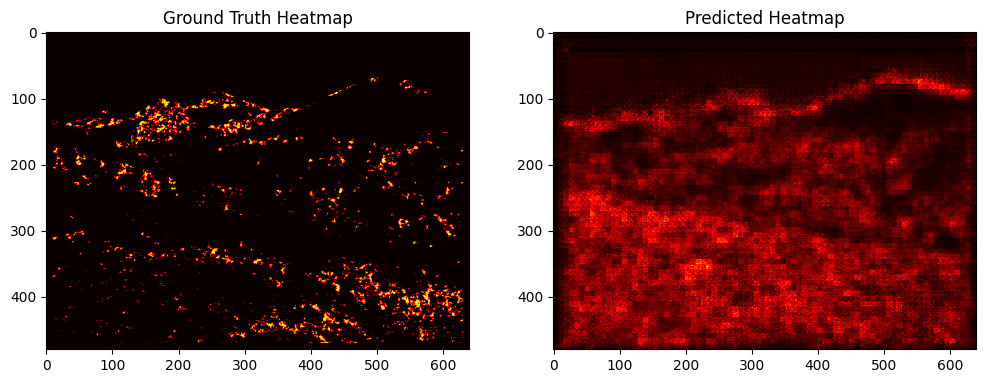

Epoch 1/19 | Train Loss: 0.5958 | Val Loss: 0.5477 | Global L2: 0.8205 | Local L2: 0.7740 | Detector CE: 0.1929 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 2/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.55it/s]


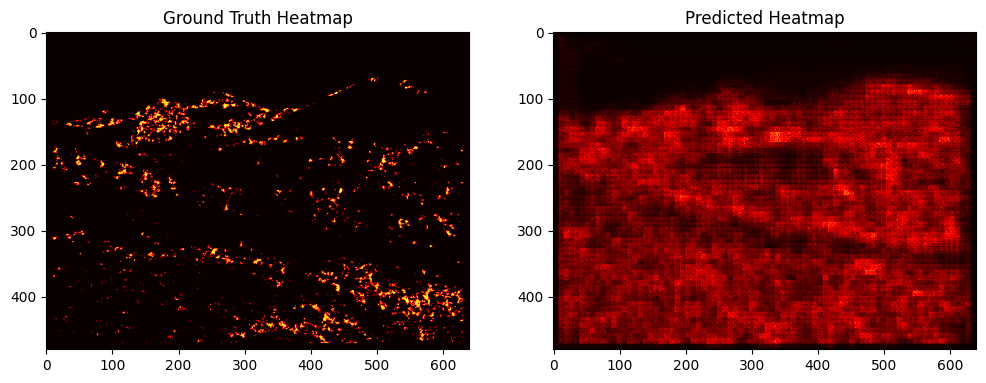

Epoch 2/19 | Train Loss: 0.5374 | Val Loss: 0.5493 | Global L2: 0.8037 | Local L2: 0.7524 | Detector CE: 0.0561 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 3/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.40it/s]


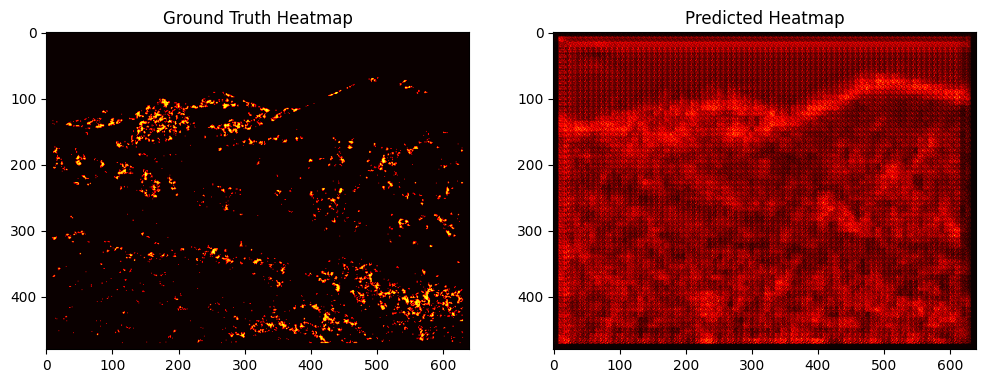

Epoch 3/19 | Train Loss: 0.5351 | Val Loss: 0.5643 | Global L2: 0.7985 | Local L2: 0.7518 | Detector CE: 0.0551 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 4/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.03it/s]


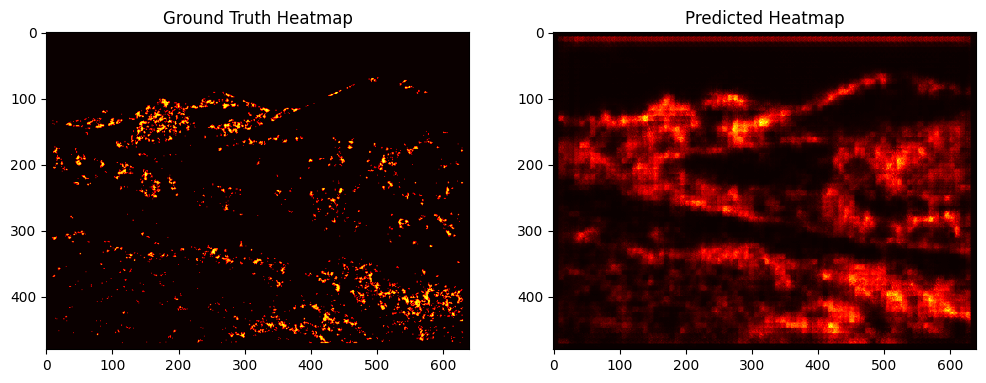

Epoch 4/19 | Train Loss: 0.5327 | Val Loss: 0.5408 | Global L2: 0.7925 | Local L2: 0.7517 | Detector CE: 0.0538 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 5/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.17it/s]


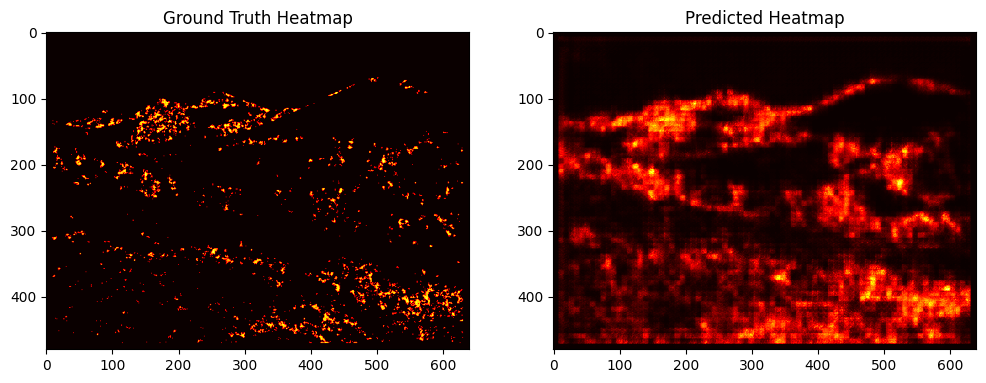

Epoch 5/19 | Train Loss: 0.5313 | Val Loss: 0.5444 | Global L2: 0.7895 | Local L2: 0.7516 | Detector CE: 0.0527 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 6/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.39it/s]


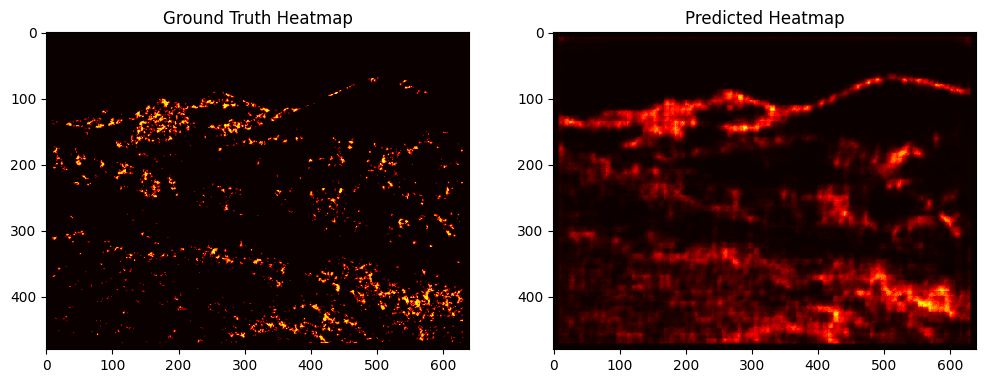

Epoch 6/19 | Train Loss: 0.5286 | Val Loss: 0.5375 | Global L2: 0.7829 | Local L2: 0.7514 | Detector CE: 0.0515 | LR: 0.001000
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 7/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.08it/s]


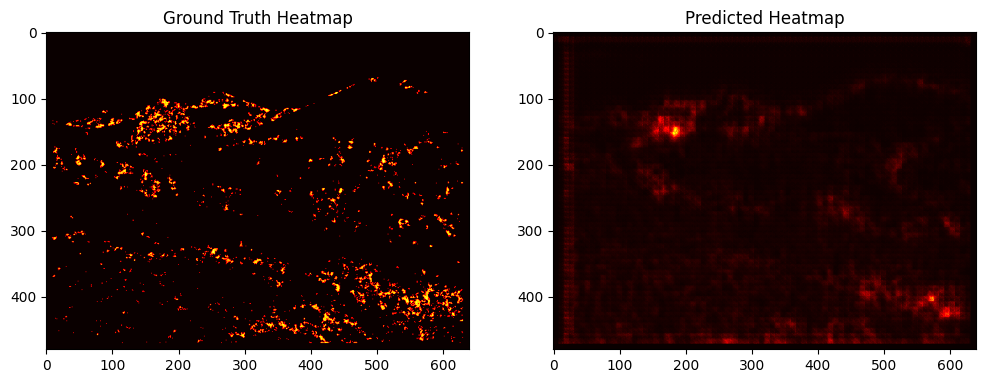

Epoch 7/19 | Train Loss: 0.5270 | Val Loss: 0.5477 | Global L2: 0.7789 | Local L2: 0.7514 | Detector CE: 0.0508 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 8/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


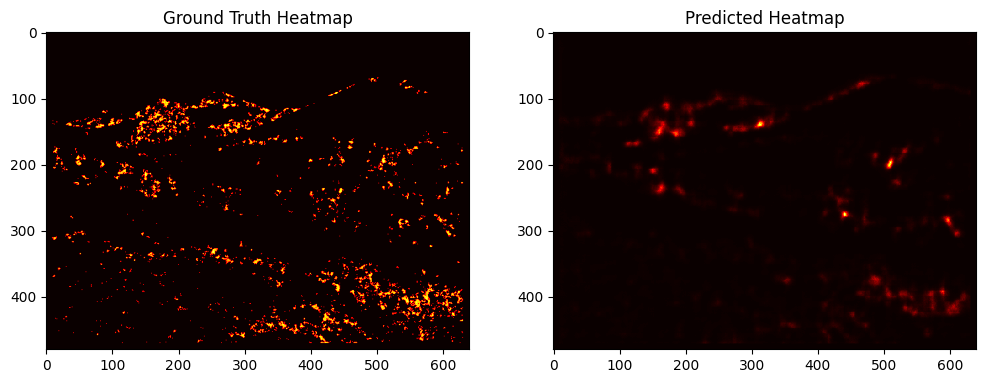

Epoch 8/19 | Train Loss: 0.5176 | Val Loss: 0.5329 | Global L2: 0.7528 | Local L2: 0.7507 | Detector CE: 0.0494 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 9/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.77it/s]


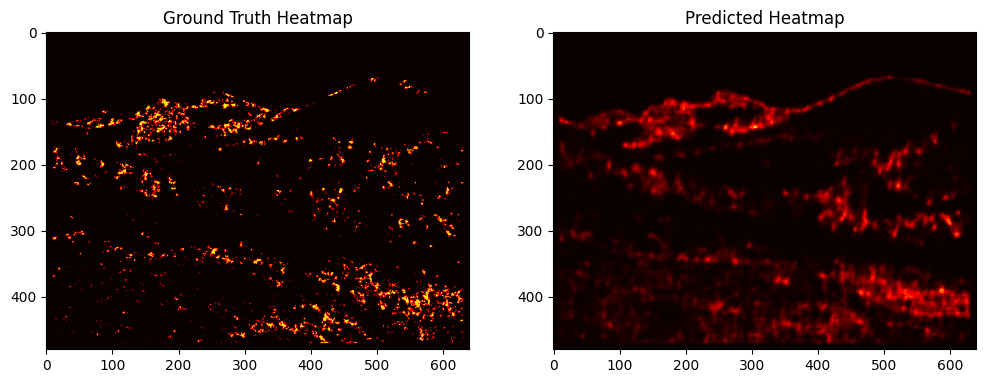

Epoch 9/19 | Train Loss: 0.5140 | Val Loss: 0.5331 | Global L2: 0.7424 | Local L2: 0.7504 | Detector CE: 0.0491 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 10/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


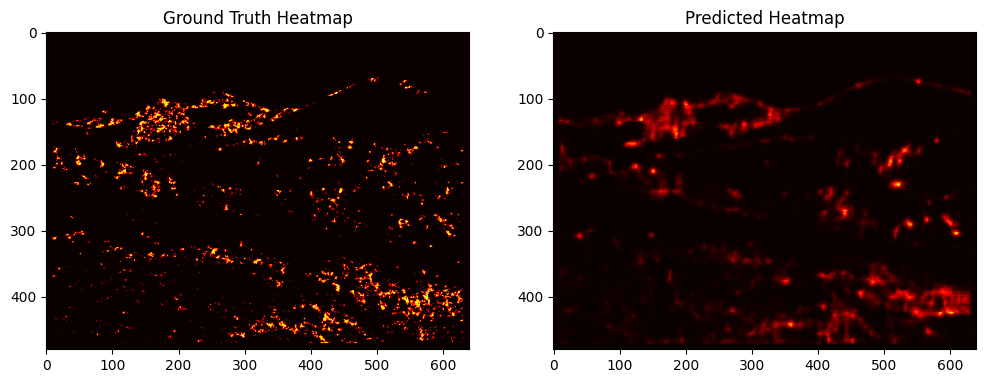

Epoch 10/19 | Train Loss: 0.5108 | Val Loss: 0.5387 | Global L2: 0.7332 | Local L2: 0.7503 | Detector CE: 0.0488 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 11/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 20.96it/s]


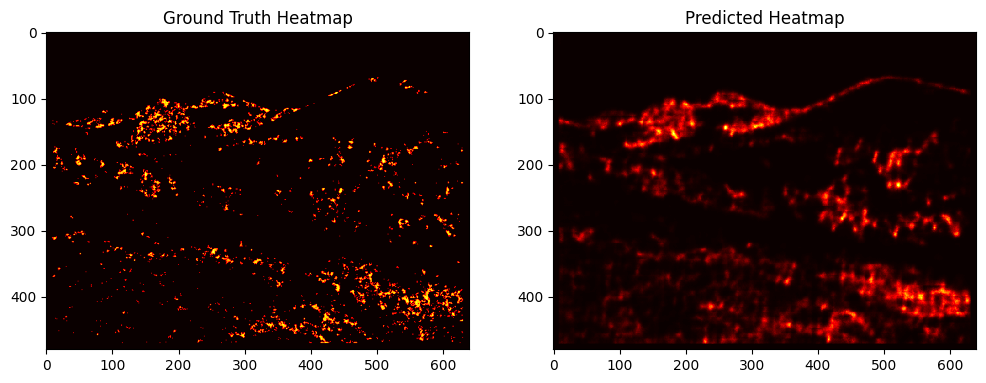

Epoch 11/19 | Train Loss: 0.5063 | Val Loss: 0.5435 | Global L2: 0.7201 | Local L2: 0.7501 | Detector CE: 0.0485 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 12/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.12it/s]


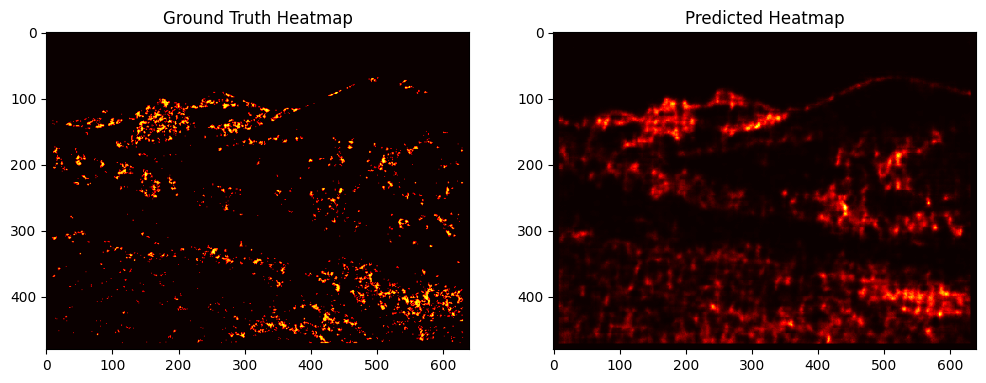

Epoch 12/19 | Train Loss: 0.5000 | Val Loss: 0.5449 | Global L2: 0.7017 | Local L2: 0.7500 | Detector CE: 0.0484 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 13/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 20.92it/s]


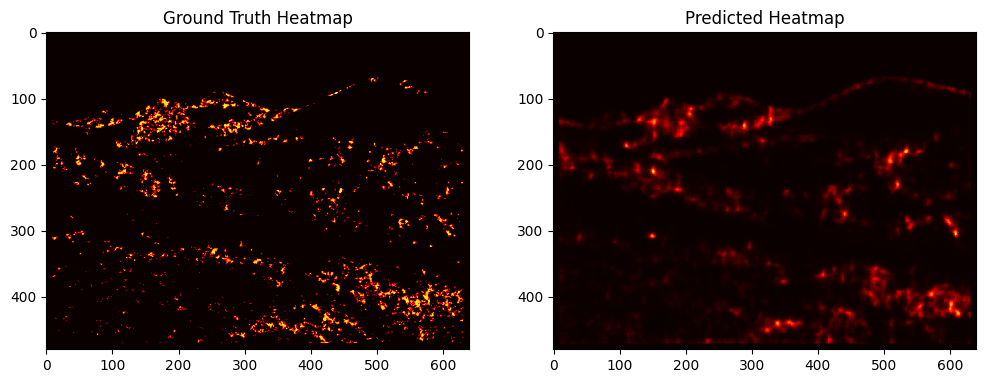

Epoch 13/19 | Train Loss: 0.4914 | Val Loss: 0.5547 | Global L2: 0.6762 | Local L2: 0.7498 | Detector CE: 0.0483 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 14/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.34it/s]


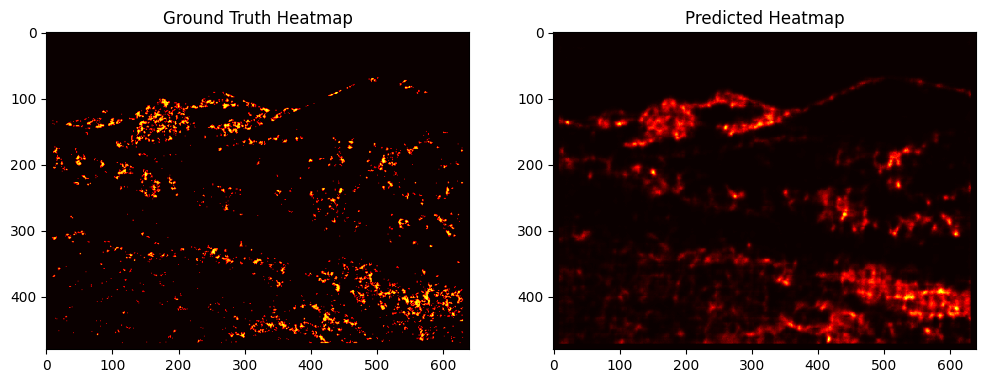

Epoch 14/19 | Train Loss: 0.4787 | Val Loss: 0.5667 | Global L2: 0.6384 | Local L2: 0.7497 | Detector CE: 0.0481 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000


Epoch 15/19 [Val]: 100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


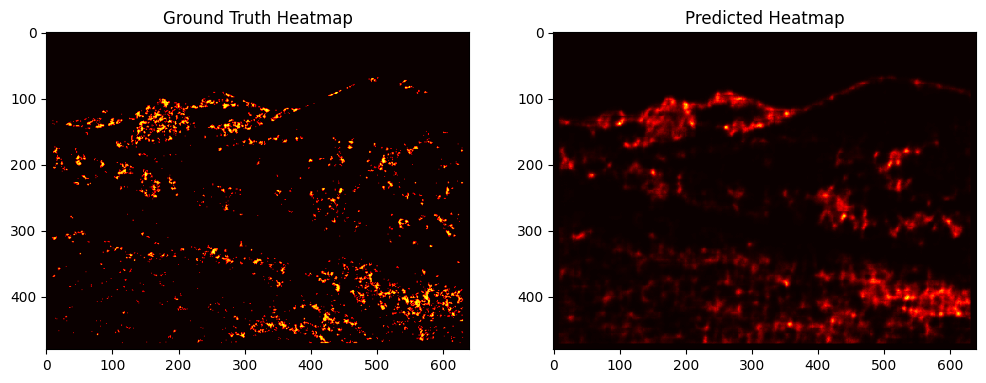

Epoch 15/19 | Train Loss: 0.4636 | Val Loss: 0.5564 | Global L2: 0.5931 | Local L2: 0.7496 | Detector CE: 0.0480 | LR: 0.000100
global: 1.0000 | local: 1.0000 | detector: 1.0000
Early stopping triggered.


In [64]:
setseed(42)
config= {
    'image_channels':1,
    # 'loss_weights': 'uncertainties',
    'loss_weights':{
        'global':1,
        'local':1,
        'detector':1
    },
    'local_head': {
        'descriptor_dim': 128,
        'detector_grid': 8,
        'input_channels': 96
    },
    'global_head': {
        'n_clusters': 32,
        'intermediate_proj': 0,
        'dimensionality_reduction': 4096
    }
}
model = HFNet(config, width_mult=0.75)

train_model(model, train_loader, val_loader, config, lr=1e-3, patience=[7], epochs=19)